https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4808230&utm_source=substack&utm_medium=email

Short and Long VIX based on NDX100

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt

In [2]:
spx_data = yf.download('^GSPC', start='2010-01-01', end='2023-01-01')  # S&P 500 Index
vix_data = yf.download('^VIX', start='2010-01-01', end='2023-01-01')  # VIX Index
df = spx_data[['Close']].rename(columns={'Close': 'SPX_Close'}).join(
    vix_data[['Close']].rename(columns={'Close': 'VIX_Close'}), how='inner'
).dropna()
df.columns = df.columns.droplevel(1)
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,SPX_Close,VIX_Close
Date,,
2010-01-04 00:00:00+00:00,1132.989990,20.040001
2010-01-05 00:00:00+00:00,1136.520020,19.350000
2010-01-06 00:00:00+00:00,1137.140015,19.160000
2010-01-07 00:00:00+00:00,1141.689941,19.059999
2010-01-08 00:00:00+00:00,1144.979980,18.129999
...,...,...
2022-12-23 00:00:00+00:00,3844.820068,20.870001
2022-12-27 00:00:00+00:00,3829.250000,21.650000
2022-12-28 00:00:00+00:00,3783.219971,22.139999


In [3]:
df['RSI_2'] = ta.rsi(df['SPX_Close'], length=2)

In [4]:
# Generate signals based on RSI(2) strategy
df['Signal'] = 0  # Flat by default
df.loc[df['RSI_2'] <= 30, 'Signal'] = -1  # Short VX if RSI <= 30
df.loc[df['RSI_2'] > 90, 'Signal'] = 1   # Buy VX if RSI > 90

# Shift signal to hold the position the next day
df['Position'] = df['Signal'].shift()

# Calculate absolute returns of VIX
df['VX_Absolute_Returns'] = df['VIX_Close'].diff()
df['SPX_Returns'] = df['SPX_Close'].pct_change()

# Apply strategy returns (using absolute returns)
df['Strategy_Absolute_Returns'] = df['Position'] * df['VX_Absolute_Returns']

# Cumulative sum for the strategy's performance
df['Cumulative_Strategy_Performance'] = df['Strategy_Absolute_Returns'].cumsum()

# Benchmark: cumulative absolute returns of holding VIX
df['VX_Benchmark'] = df['VX_Absolute_Returns'].cumsum()
df['SPX_Benchmark'] = ((1 + df['SPX_Returns']).cumprod() - 1)*100

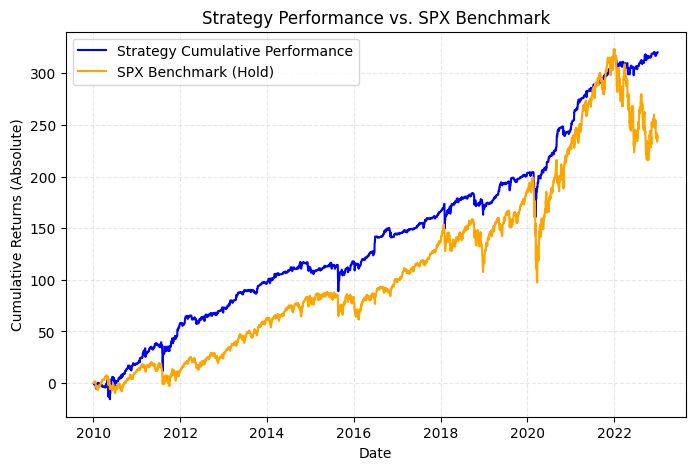

In [5]:
# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(df['Cumulative_Strategy_Performance'], label='Strategy Cumulative Performance', color='blue')
plt.plot(df['SPX_Benchmark'], label='SPX Benchmark (Hold)', color='orange')
plt.legend()
plt.title('Strategy Performance vs. SPX Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (Absolute)')
plt.grid(linestyle="--",alpha=0.3)
plt.show()